In [1]:
import os
from matplotlib import pyplot as plt

from blankspace.utils import geotiff_to_numpy, minmax_scaling, get_image_collection
from blankspace.pca import pca_image_decomposition, pca_series_decomposition

# PCA on GeoTiff

The aim of this notebook is to read in a `GeoTiff` raster of information and decompose all the bands into a single image through [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

### Import image and convert to numerical arrays

In [2]:
image_name = "20180926-kortgene"
image_folder = os.path.join("data", image_name)

In [3]:
band_names, image = geotiff_to_numpy(image_folder)
height, width, bands = image.shape
band_names, image.shape

(['B8', 'B2', 'WVP', 'B3', 'B4', 'AOT'], (174, 252, 6))

Let's try displaying band "WVP"

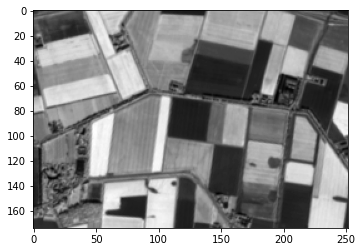

In [4]:
wvp = image[:, :, 0]
plt.imshow(wvp, cmap="gray")

### Apply PCA to all data

We use the function defined in `blankspace/pca.py`, which returns us the final image and the ratio of explained variance from PCA

In [5]:
pca_image, ratio = pca_image_decomposition(image)
ratio

0.9977545141374667

We can now display the images with matplotlib, playing with which band to assing to each colour by simply reordering the bands in the output

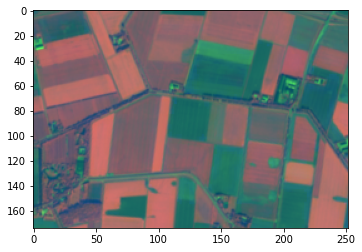

In [6]:
plt.imshow(pca_image)

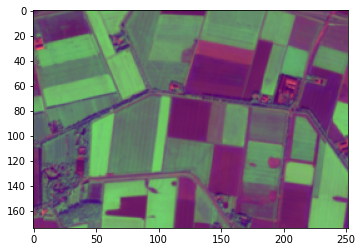

In [7]:
plt.imshow(pca_image[:, :, [1, 0, 2]])

And finally, save the image

In [8]:
output_pca_path = os.path.join("out", "pca", f"{image_name}.png")
plt.imsave(output_pca_path, pca_image[:, :, [1, 0, 2]])

For comparison, here is the original image with the original RGB bands (respectively B2, B3 and B4)

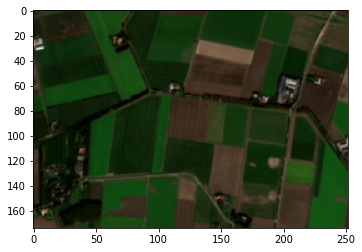

In [9]:
bands_idx = [band_names.index(band_name) for band_name in ["B4", "B3", "B2"]]
original_image = minmax_scaling(image[:, :, bands_idx])
plt.imshow(original_image)

In [10]:
output_original_path = os.path.join("out", "original", f"{image_name}.png")
plt.imsave(output_original_path, original_image)

## Multiple image PCA

The idea is to try and compute a PCA decomposition using all bands from a lot of different images in different times.

First, we get a collection of many images:

In [11]:
base_path = "data/"
image_name = "combined_sentinel_kortgene"
paths = [
    os.path.join(base_path, path) 
    for path in os.listdir(base_path)
    if path.endswith("kortgene")
]
collection = get_image_collection(paths)

Then we compute PCA decomposition, considering as bands all the bands of the images in collection

In [12]:
pca_combined_image, ratio = pca_series_decomposition(collection)
print(f"PCA decomposition is able to account for {ratio * 100}% of the variance")

PCA decomposition is able to account for 96.191784286184% of the variance


We get this result:

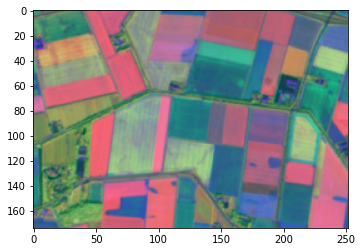

In [13]:
plt.imshow(pca_combined_image)

In [14]:
pca_combined_path = os.path.join("out", "pca", f"{image_name}.png")
plt.imsave(pca_combined_path, pca_combined_image)